#### Drought occurence, duration, reduction in generation and duration vs installed capacity

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import numpy as np
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Set publication-quality style parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 300,
    'savefig.dpi': 600
})


Read global hybrid prediction data

In [ ]:
input_global_dir = "/scratch/shah0012/hybrid_hydropower_model/hybrid_model_results/"
input_global_data = pd.read_csv(input_global_dir + "global_data_prediction_designed_dataset_drought_attributes_included_1982_2022_target_CF.csv", parse_dates=["date"])

glohydrores_file = "/home/shah0012/GloHydroRes/Output_data/GloHydroRes_vs2.xlsx"
glohydrores_df = pd.read_excel(glohydrores_file, sheet_name="Data")    
input_global_data["country"] = input_global_data.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["country"])))
input_global_data["plant_type"] = input_global_data.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_type"])))
input_global_data["month"] = input_global_data.date.dt.month
# Create a unique indicator which if drought it 1 otherwise 0
input_global_data["drought_indicator"] = (input_global_data.drought_20_pooled_3length > 0).astype(int)

Check stats for manuscript

In [12]:
print(f"For {input_global_data.glohydrores_plant_id.nunique()} hydropower plants analysis was done")
print(f"Total global installed capacity: {input_global_data.drop_duplicates(subset = 'glohydrores_plant_id').installed_capacity_mw.sum()/1000}")
print(f"Number of countries for which analysis was done: {input_global_data.drop_duplicates(subset = 'glohydrores_plant_id').country.nunique()}")
unique_plant_data = input_global_data.drop_duplicates(subset = "glohydrores_plant_id")
print(f"Total global ROR installed capacity: {unique_plant_data[unique_plant_data.plant_type == 'ROR'].installed_capacity_mw.sum()/1000}")
print(f"Total global STO installed capacity: {unique_plant_data[unique_plant_data.plant_type == 'STO'].installed_capacity_mw.sum()/1000}")


For 3910 hydropower plants analysis was done
Total global installed capacity: 902.6050819999999
Number of countries for which analysis was done: 120
Total global ROR installed capacity: 249.44015000000002
Total global STO installed capacity: 634.1280160000001


##### Number of drought events occurred at each hydropower plant

In [51]:
drought_counts = input_global_data.groupby(["glohydrores_plant_id"])["drought_20_pooled_3length"].nunique().reset_index()
drought_counts.rename(columns = {"drought_20_pooled_3length": "number_of_events"}, inplace=True)
drought_counts["number_of_events"] = drought_counts.number_of_events - 1
drought_counts["plant_type"]  =  drought_counts.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_type"])))
drought_counts["plant_lat"]  =  drought_counts.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_lat"])))
drought_counts["plant_lon"]  =  drought_counts.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_lon"])))

In [52]:
def plot_drought_events_func(drought_count_array, figure_name):
    plant_lat = drought_count_array.plant_lat.values
    plant_lon = drought_count_array.plant_lon.values
    drought_count = drought_count_array.number_of_events.values

    fig = plt.figure(figsize=(6,4), dpi = 100)
    gs = GridSpec(1,1)

    ax1 = fig.add_subplot(gs[0])
    m1 = Basemap(
         projection='cyl',
         llcrnrlat=-60,
         urcrnrlat=90,
         llcrnrlon=-180,
         urcrnrlon=180,
         resolution='i',
         ax=ax1
    )

    m1.drawcoastlines(linewidth=0.3, color="gray")
    m1.fillcontinents(color="whitesmoke", lake_color='white', zorder=1)
    m1.drawcountries(linewidth=0.2, color='gray')
    boundaries = np.arange(3, 24, 3)

    # Plot points
    sc1 = ax1.scatter(
        plant_lon, plant_lat,
        c=drought_count,
        zorder=5,
        s = 15,
        alpha=0.9,
        edgecolors='black',
        linewidth=0.1, 
        cmap="YlOrRd",
        vmin=3, vmax=21
    )
    cbar = plt.colorbar(sc1, ax=ax1, orientation="vertical", pad=0.02, 
                    shrink=0.5, extend="both", spacing='proportional')

    cbar.set_ticks(boundaries)
    cbar.ax.tick_params(labelsize=11)
    plt.tight_layout()
    plt.savefig(f"/home/shah0012/Hydropower_hybrid_model/figures/{figure_name}.png", dpi=600, bbox_inches='tight')
    plt.show()





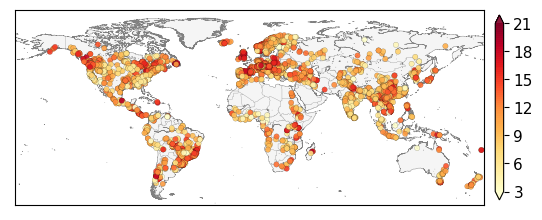

In [53]:
plot_drought_events_func(drought_count_array = drought_counts, figure_name = "number_drought_events")

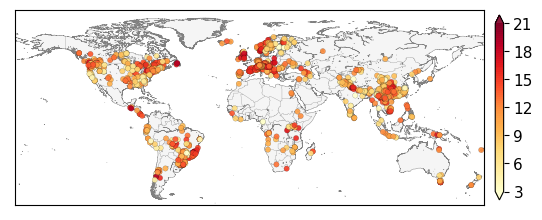

In [54]:
#For ROR plant number of events
ROR_drought_counts = drought_counts[drought_counts.plant_type == "ROR"]
plot_drought_events_func(drought_count_array = ROR_drought_counts, figure_name = "ROR_drought_events")

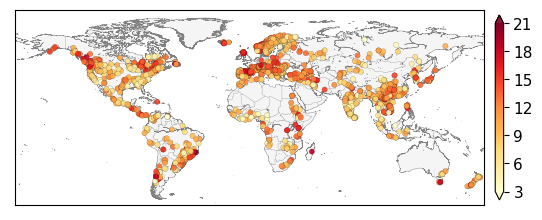

In [55]:
#For ROR plant number of events
STO_drought_counts = drought_counts[drought_counts.plant_type == "STO"]
plot_drought_events_func(drought_count_array = STO_drought_counts, figure_name = "STO_drought_events")

##### Average drought duration at each hydropower plant

In [58]:
input_global_data['drought_length']  = (
    input_global_data.groupby(['glohydrores_plant_id', 'drought_20_pooled_3length'])['drought_20_pooled_3length']
      .transform('count')
) # transform keeps datafram size same

input_global_data.loc[input_global_data.drought_indicator == 0, "drought_length"] = 0

In [60]:
average_length_each_plant = (input_global_data.groupby("glohydrores_plant_id")["drought_length"]
.apply(lambda x : x[x>0].mean()).reset_index()
)

average_length_each_plant["plant_type"]  =  average_length_each_plant.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_type"])))
average_length_each_plant["plant_lat"]  =  average_length_each_plant.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_lat"])))
average_length_each_plant["plant_lon"]  =  average_length_each_plant.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_lon"])))


In [63]:
def plot_drought_duration_func(drought_duration_array, filename):
    plant_lat = drought_duration_array.plant_lat.values
    plant_lon = drought_duration_array.plant_lon.values
    drought_length = drought_duration_array.drought_length.values
    fig = plt.figure(figsize=(6,4), dpi = 300)
    gs = GridSpec(1,1)
    ax1 = fig.add_subplot(gs[0])
    m1 = Basemap(
        projection='cyl',
        llcrnrlat=-60,
        urcrnrlat=90,
        llcrnrlon=-180,
        urcrnrlon=180,
        resolution='i',
        ax=ax1)
    m1.drawcoastlines(linewidth=0.3, color="gray")
    m1.fillcontinents(color="whitesmoke", lake_color='white', zorder=1)
    m1.drawcountries(linewidth=0.2, color='gray')
    boundaries = np.arange(3, 33, 3)
    sc1 = ax1.scatter(
        plant_lon, plant_lat,
        c=drought_length,
        zorder=5,
        s = 15,
        alpha=0.9,
        edgecolors='black',
        linewidth=0.1, 
        cmap="YlOrRd",
        vmin = 3, vmax = 30
    )
    cbar = plt.colorbar(sc1, ax=ax1, orientation="vertical", pad=0.02, 
                    shrink=0.5, extend="both", spacing='proportional')
    cbar.set_ticks(boundaries)
    cbar.ax.tick_params(labelsize=11)
    plt.tight_layout()
    plt.savefig(f"/home/shah0012/Hydropower_hybrid_model/figures/{filename}.png", dpi=600, bbox_inches='tight')
    plt.show()






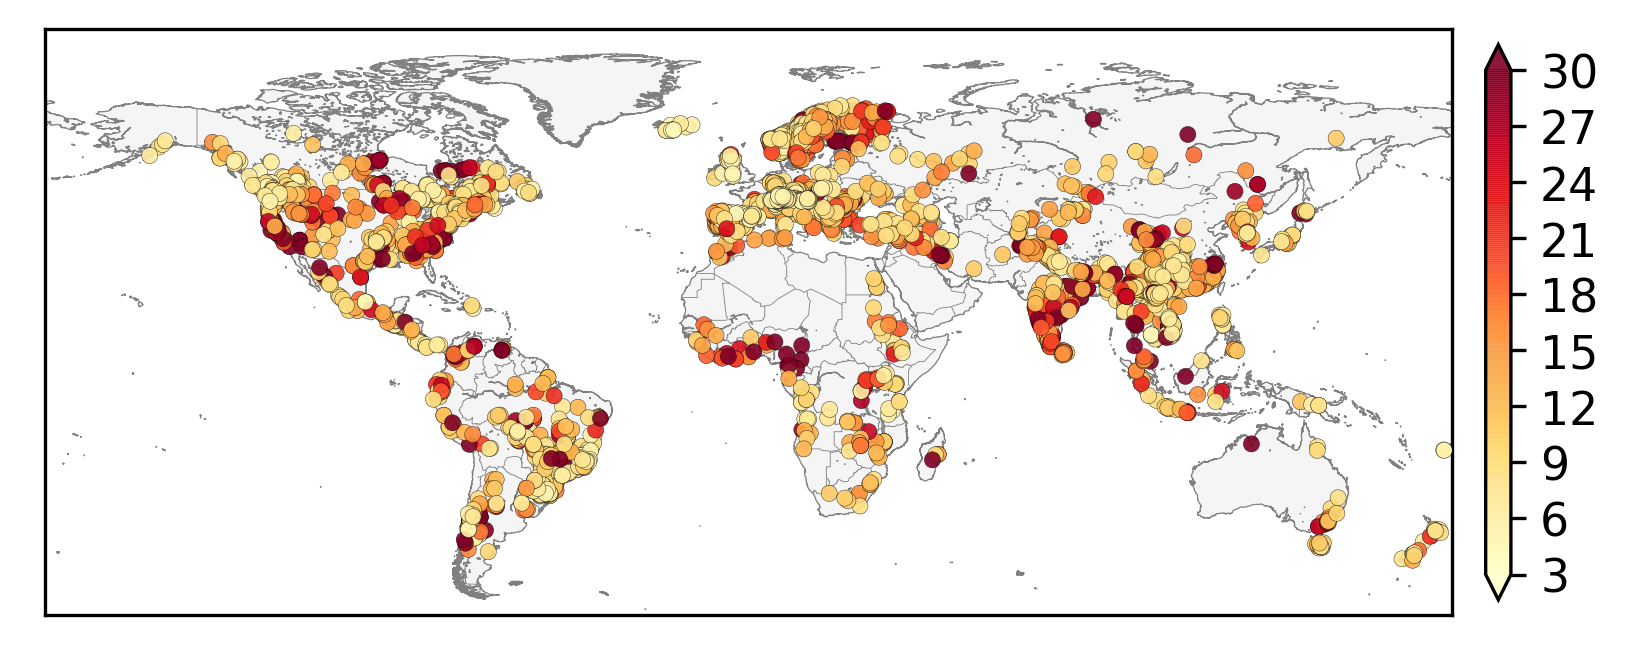

In [65]:
plot_drought_duration_func(drought_duration_array = average_length_each_plant, filename = "average_drought_length")

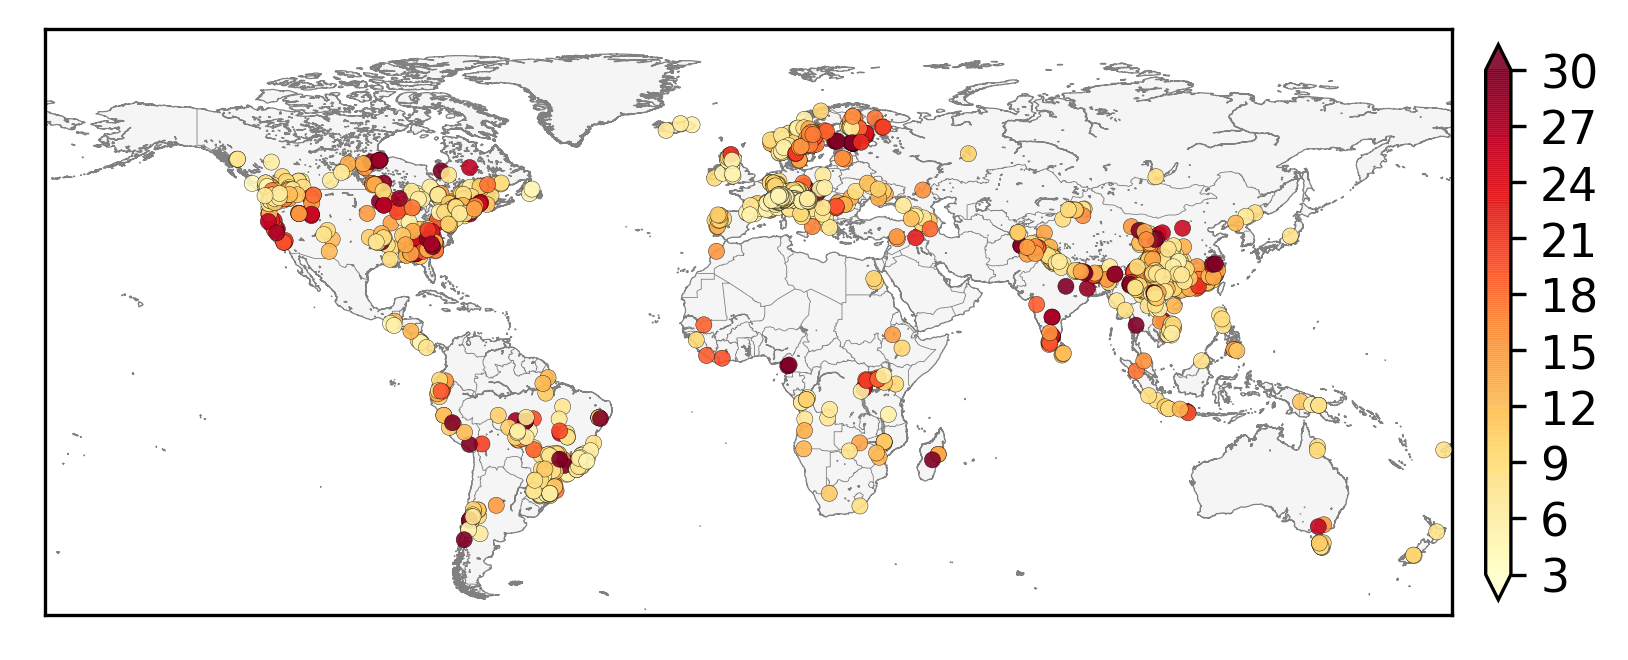

In [ ]:
#For ROR plants average drought duration
ROR_drought_duration = average_length_each_plant[average_length_each_plant.plant_type == "ROR"]
plot_drought_duration_func(drought_duration_array = ROR_drought_duration, filename = "ROR_average_drought_length")

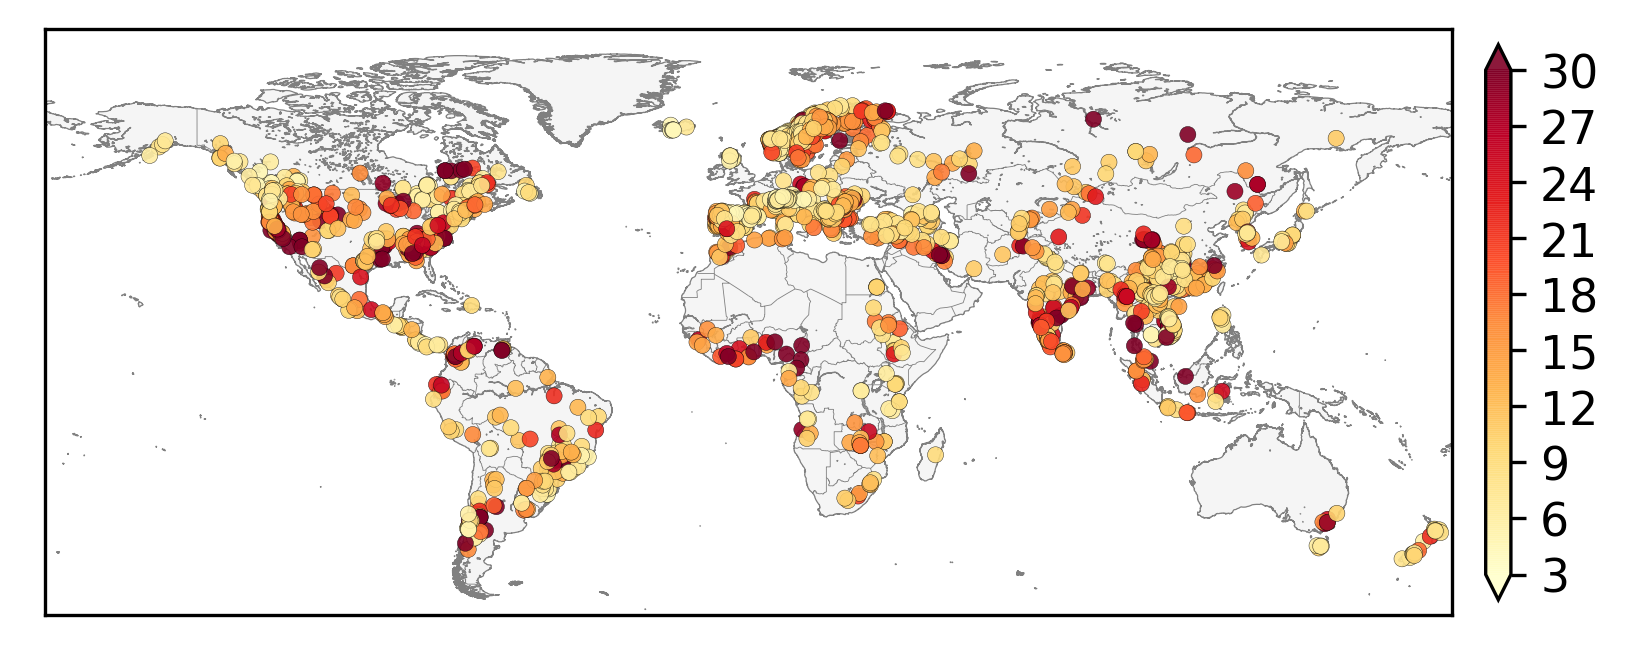

In [68]:
#For STO plant number of events
STO_drought_duration = average_length_each_plant[average_length_each_plant.plant_type == "STO"]
plot_drought_duration_func(drought_duration_array = STO_drought_duration, filename = "STO_average_drought_length")

##### Reduction in generation during drought

In [69]:
monthly_average_prediction_during_drought = input_global_data[input_global_data["drought_indicator"] == 1].groupby(["month", "glohydrores_plant_id"])["originial_prediction"].mean().reset_index()
monthly_average_prediction_during_drought.rename(columns = {"originial_prediction" : "average_prediction_during_drought"}, inplace = True)
long_term_mean = input_global_data.groupby(["month", "glohydrores_plant_id"])["originial_prediction"].mean().reset_index()
long_term_mean.rename(columns = {"originial_prediction" : "long_term_mean_prediction"}, inplace = True)
monthly_average_prediction_during_drought = monthly_average_prediction_during_drought.merge(long_term_mean, on = ["month", "glohydrores_plant_id"], how = "left")

Average deviation from during drought compared to long term mean generation

In [71]:
monthly_average_prediction_during_drought["deviation_longterm"] = ((monthly_average_prediction_during_drought.average_prediction_during_drought - monthly_average_prediction_during_drought.long_term_mean_prediction)/(monthly_average_prediction_during_drought.long_term_mean_prediction))*100

Average long term deviation

In [ ]:
overall_reduction =  monthly_average_prediction_during_drought.groupby("glohydrores_plant_id")["deviation_longterm"].mean().reset_index()
overall_reduction["plant_type"]  =  overall_reduction.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_type"])))
overall_reduction["plant_lat"]  =  overall_reduction.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_lat"])))
overall_reduction["plant_lon"]  =  overall_reduction.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["plant_lon"])))


In [77]:
def generation_reduction_func(generation_reduction_array, filename):
    from matplotlib.colors import BoundaryNorm
    from matplotlib import cm

    plant_lat = generation_reduction_array.plant_lat.values
    plant_lon = generation_reduction_array.plant_lon.values
    generation_reduction = generation_reduction_array.deviation_longterm.values

    fig = plt.figure(figsize=(6,4), dpi = 300)
    gs = GridSpec(1,1)

    ax1 = fig.add_subplot(gs[0])

    m1 = Basemap(
        projection="cyl",
        llcrnrlat=-60,
        urcrnrlat=90,
        llcrnrlon=-180,
        urcrnrlon=180,
        resolution='i',
        ax=ax1
    )

    m1.drawcoastlines(linewidth=0.3, color='gray')
    m1.fillcontinents(color="whitesmoke", lake_color='white', zorder=1)
    m1.drawcountries(linewidth=0.2, color='gray')

    boundaries = np.arange(-20, 25, 5)

    sc1 = ax1.scatter(
        plant_lon, plant_lat,
        c=generation_reduction,
        zorder=5,
        s = 15,
        alpha=0.9,
        edgecolors='black',
        linewidth=0.1, 
        cmap="coolwarm_r",
        vmin = -20, vmax = 20
    )

    cbar = plt.colorbar(sc1, ax=ax1, orientation="vertical", pad=0.02, 
                    shrink=0.5, extend="both", spacing='proportional')
    cbar.set_ticks(boundaries)
    cbar.ax.tick_params(labelsize=11)
    plt.tight_layout()
    plt.savefig(f"/home/shah0012/Hydropower_hybrid_model/figures/{filename}.png",dpi=600, bbox_inches='tight')
    plt.show()


    
    

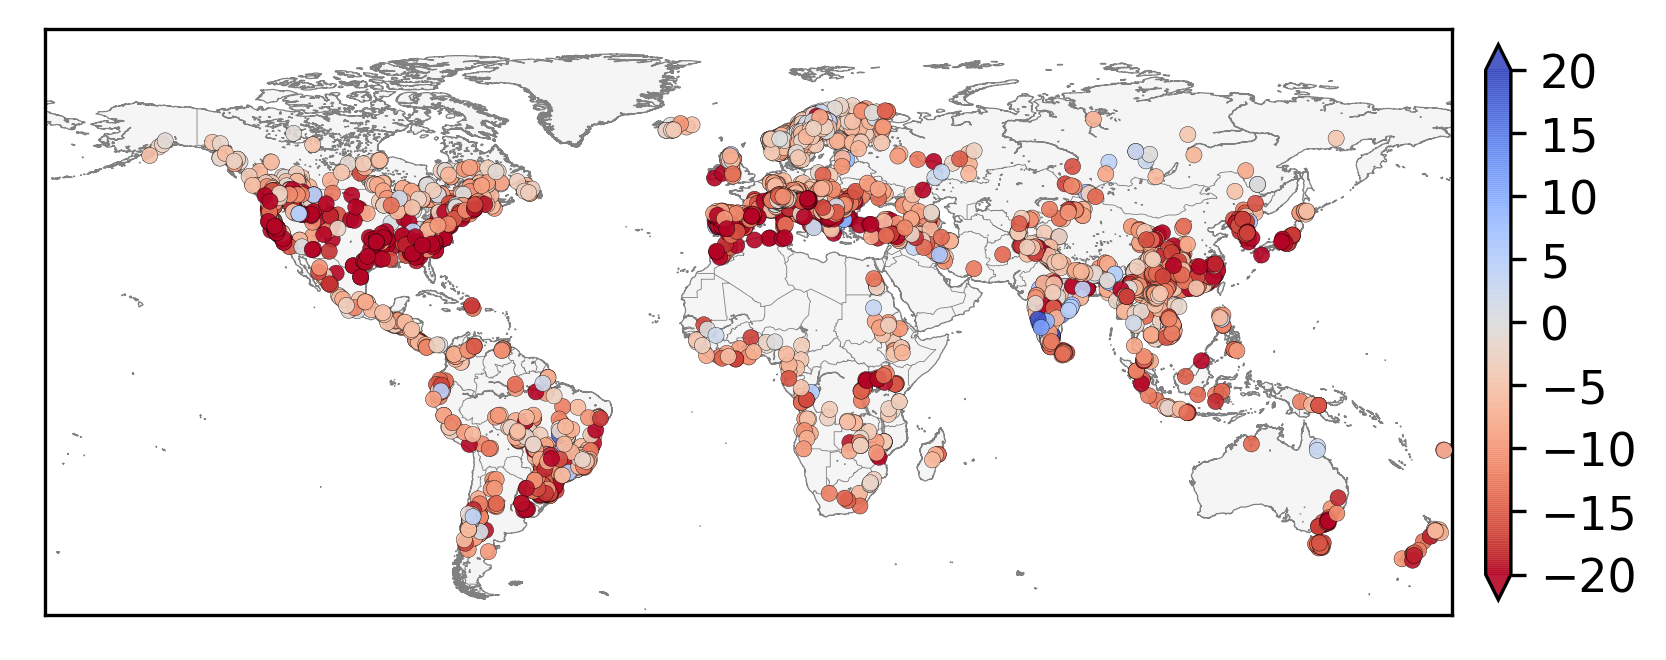

In [78]:
generation_reduction_func(generation_reduction_array = overall_reduction, filename = "average_generation_reduction")

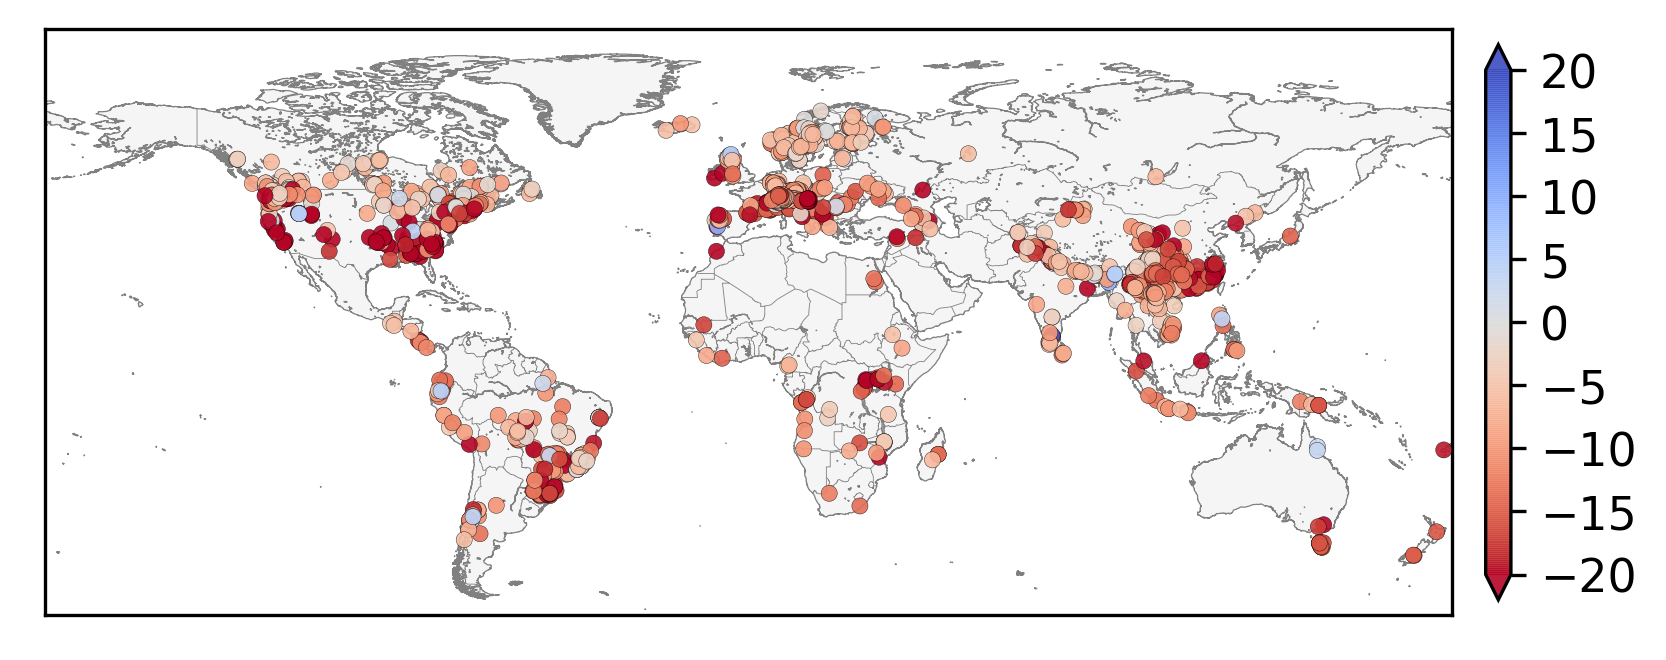

In [79]:
#For ROR plants average drought duration
ROR_overall_reduction = overall_reduction[overall_reduction.plant_type == "ROR"]
generation_reduction_func(generation_reduction_array = ROR_overall_reduction, filename = "ROR_average_generation_reduction")

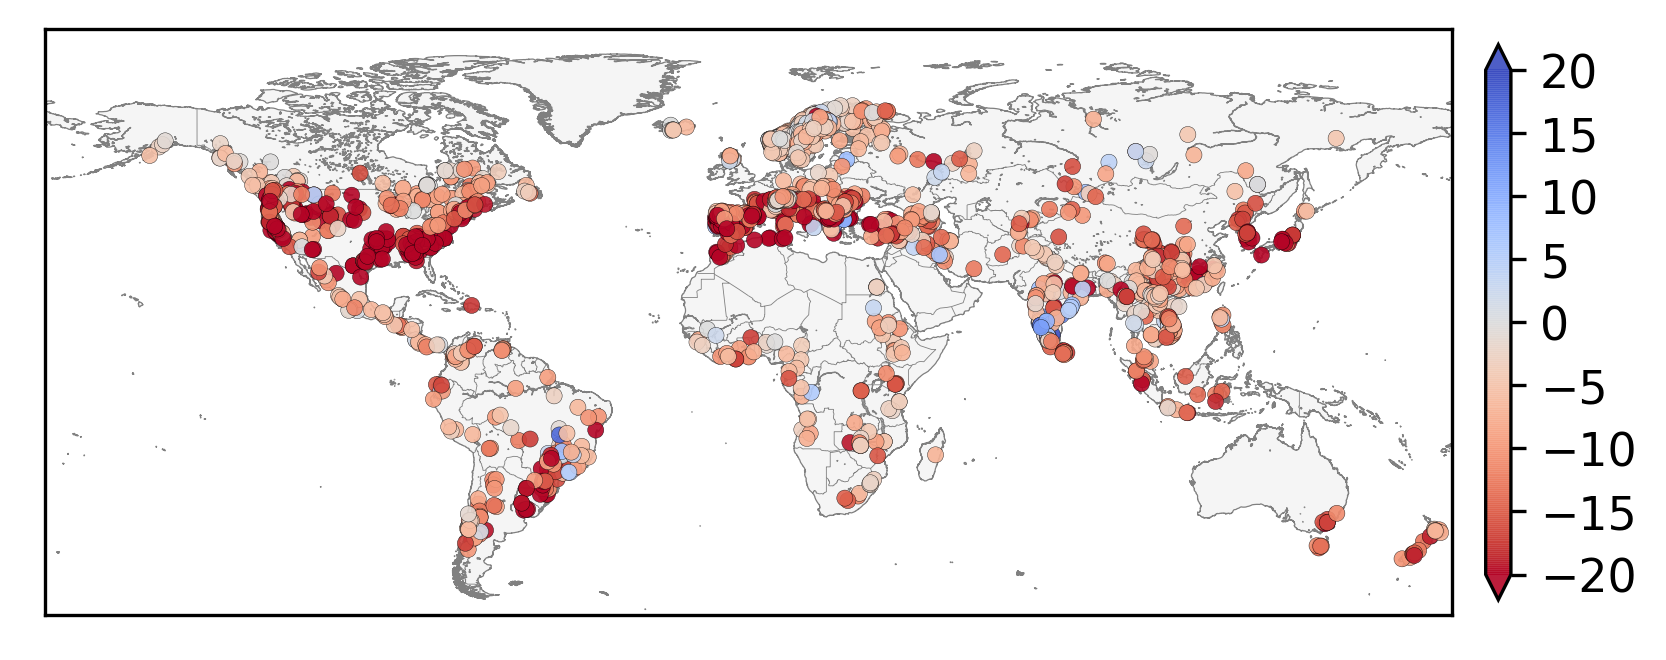

In [80]:
#For STO plants average drought duration
STO_overall_reduction = overall_reduction[overall_reduction.plant_type == "STO"]
generation_reduction_func(generation_reduction_array = STO_overall_reduction, filename = "STO_average_generation_reduction")

##### Drought duration vs Installed capacity 

In [ ]:
#Merge number of events and drought length in  reduction in generation
overall_reduction = overall_reduction.merge(drought_counts[["glohydrores_plant_id", "number_of_events"]], on = ["glohydrores_plant_id"], how = "left")
overall_reduction = overall_reduction.merge(average_length_each_plant[["glohydrores_plant_id", "drought_length"]], on = ["glohydrores_plant_id"], how = "left")


In [87]:
overall_reduction["installed_cap"] = overall_reduction.glohydrores_plant_id.map(dict(zip(glohydrores_df["ID"], glohydrores_df["capacity_mw"])))

In [94]:
input_global_data  = input_global_data.merge(long_term_mean, on = ["glohydrores_plant_id", "month"])

In [96]:
input_global_data["deviation_longterm"] =  ((input_global_data.originial_prediction - input_global_data.long_term_mean_prediction)/(input_global_data.long_term_mean_prediction))*100

In [107]:
average_deviation_each_drought = input_global_data.groupby(["glohydrores_plant_id", "drought_20_pooled_3length"])["deviation_longterm"].mean().reset_index()
average_deviation_each_drought.rename(columns =  {"deviation_longterm" : "average_deviation"}, inplace = True)
average_deviation_each_drought = average_deviation_each_drought[average_deviation_each_drought.drought_20_pooled_3length != 0]
average_deviation_each_drought  = average_deviation_each_drought.merge(input_global_data[["glohydrores_plant_id", "drought_20_pooled_3length", "drought_length"]], on = ["glohydrores_plant_id", "drought_20_pooled_3length"], how = "left")
average_deviation_each_drought["installed_cap"] = average_deviation_each_drought.glohydrores_plant_id.map(dict(zip(glohydrores_df.ID, glohydrores_df.capacity_mw)))
average_deviation_each_drought["plant_type"] = average_deviation_each_drought.glohydrores_plant_id.map(dict(zip(glohydrores_df.ID, glohydrores_df.plant_type)))

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap_installedcap_vs_drought_length(df, filename):
    capacity_bins = [0, 100, 500, 1000, 5000, df['installed_cap'].max()]
    capacity_labels = ['>100',  '100–500', '500-1000', '1000-5000', '>5000']

    # Based on drought severity classifications
    length_bins = [0, 6, 12, 24, 36,
               df['drought_length'].max()]
    length_labels = ['<6', '6-12', 
                 '12-24', '24-36', '>36']

    # Apply binning
    df['capacity_class'] = pd.cut(df['installed_cap'], bins=capacity_bins, labels=capacity_labels, include_lowest=True)
    df['length_class'] = pd.cut(df['drought_length'], bins=length_bins, labels=length_labels, include_lowest=True)

    heatmap_data = (
    df.groupby(['capacity_class', 'length_class'])['average_deviation']
      .mean()
      .unstack())

    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    
    # Plot
    cax = sns.heatmap(heatmap_data, cmap='YlOrRd_r', vmin=-12, vmax=-2, annot=True, fmt=".1f", ax = ax, linecolor = "white", linewidths = 0.5, square = False, annot_kws={'size': 12}, cbar_kws={'extend': 'both'})
    ax.set_xlabel('Drought duration (Months)', fontsize = 14,  labelpad = 10)
    ax.set_ylabel('Installed capacity (MW)', fontsize = 14,  labelpad = 10)
    ax.tick_params(labelsize=13)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(-12, 0, 2))
    #cbar.set_ticklabels(np.arange(-12, 2, 2))
    cbar.ax.tick_params(labelsize = 14)
    cbar.set_label("Average generation reduction (%)", fontsize = 14, labelpad = 10)
    plt.tight_layout()
    plt.savefig(f'/home/shah0012/Hydropower_hybrid_model/figures/{filename}.png', dpi = 600, bbox_inches='tight')  # Vector format

    plt.show()





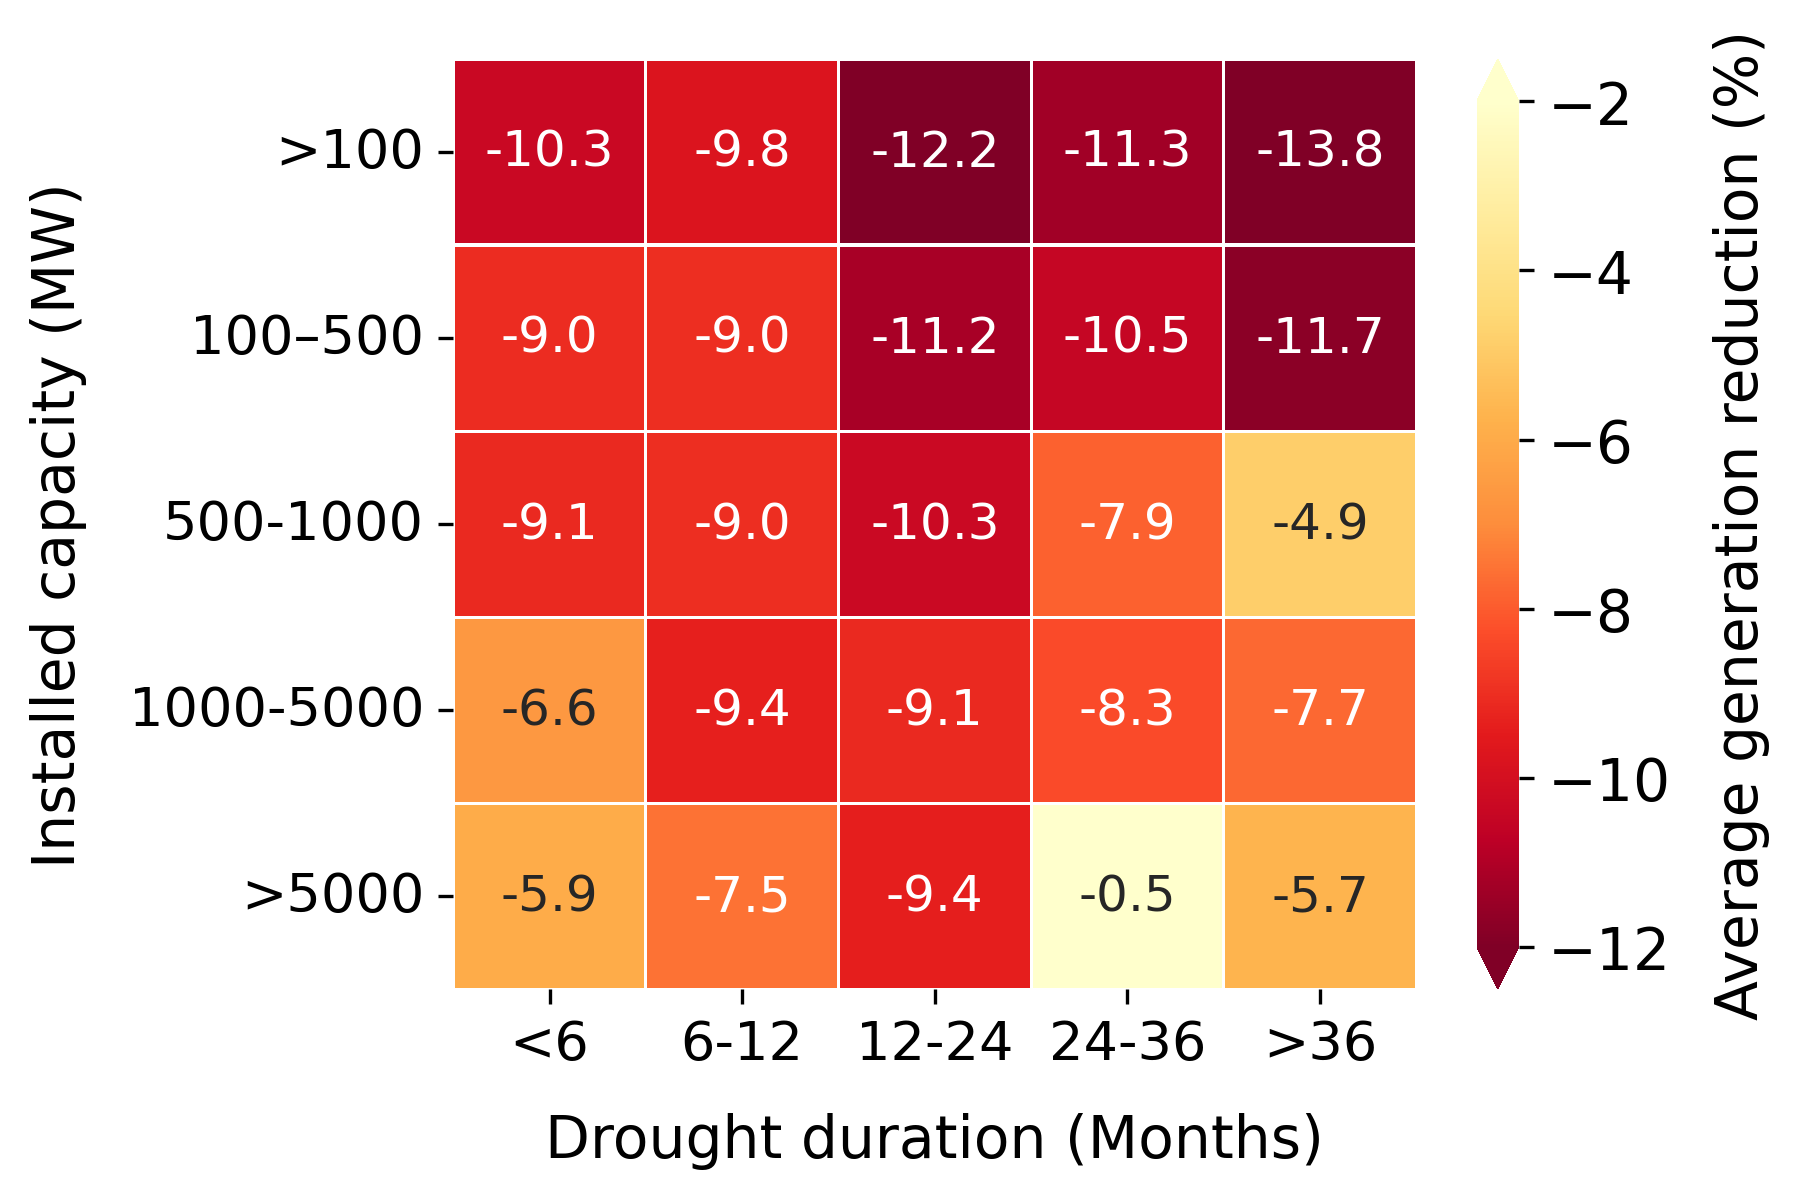

In [135]:
plot_heatmap_installedcap_vs_drought_length(df = average_deviation_each_drought, filename = "heatmap_drought_reduction_installed_cap_drought_length")

/home/shah0012/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/shah0012/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


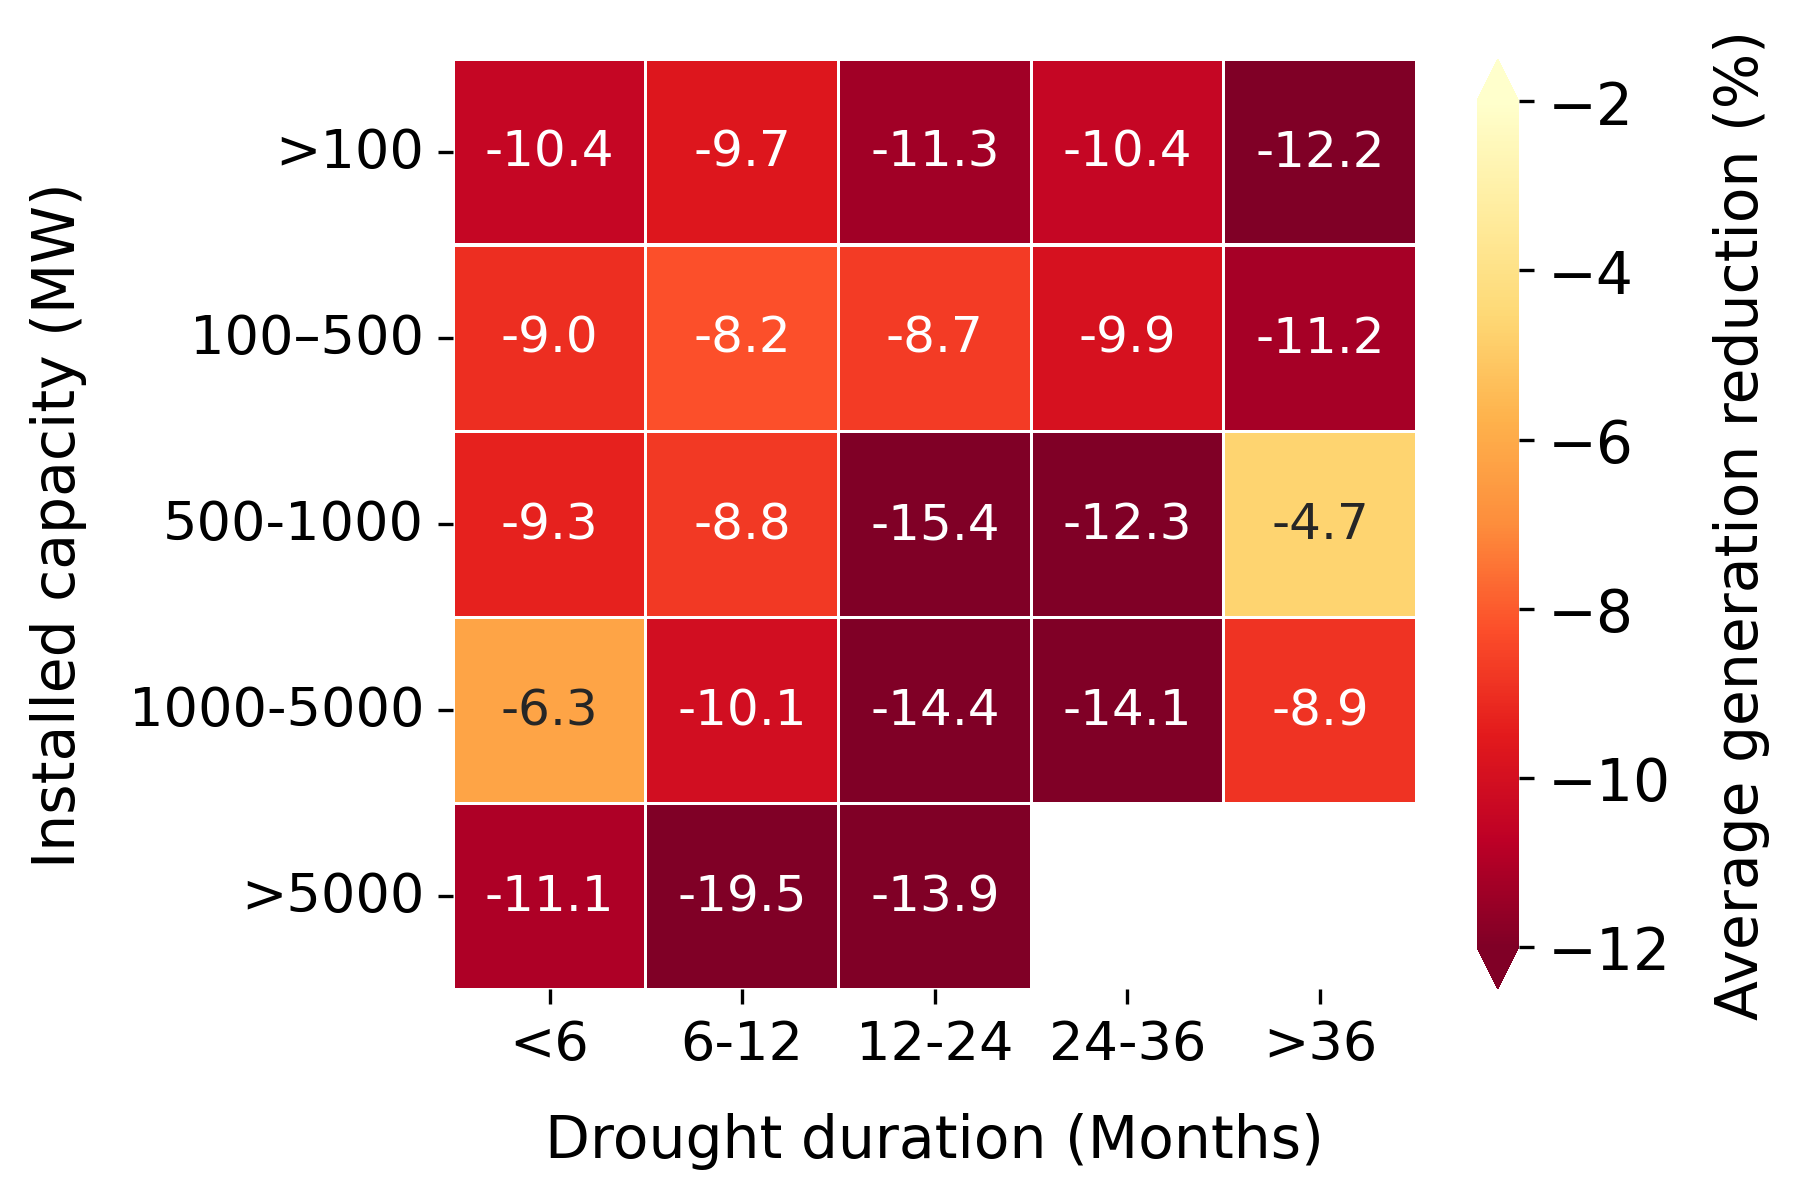

In [136]:
ROR_average_deviation_each_drought = average_deviation_each_drought[average_deviation_each_drought.plant_type == "ROR"]
plot_heatmap_installedcap_vs_drought_length(df = ROR_average_deviation_each_drought, filename = "ROR_heatmap_drought_reduction_installed_cap_drought_length")

/home/shah0012/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/shah0012/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


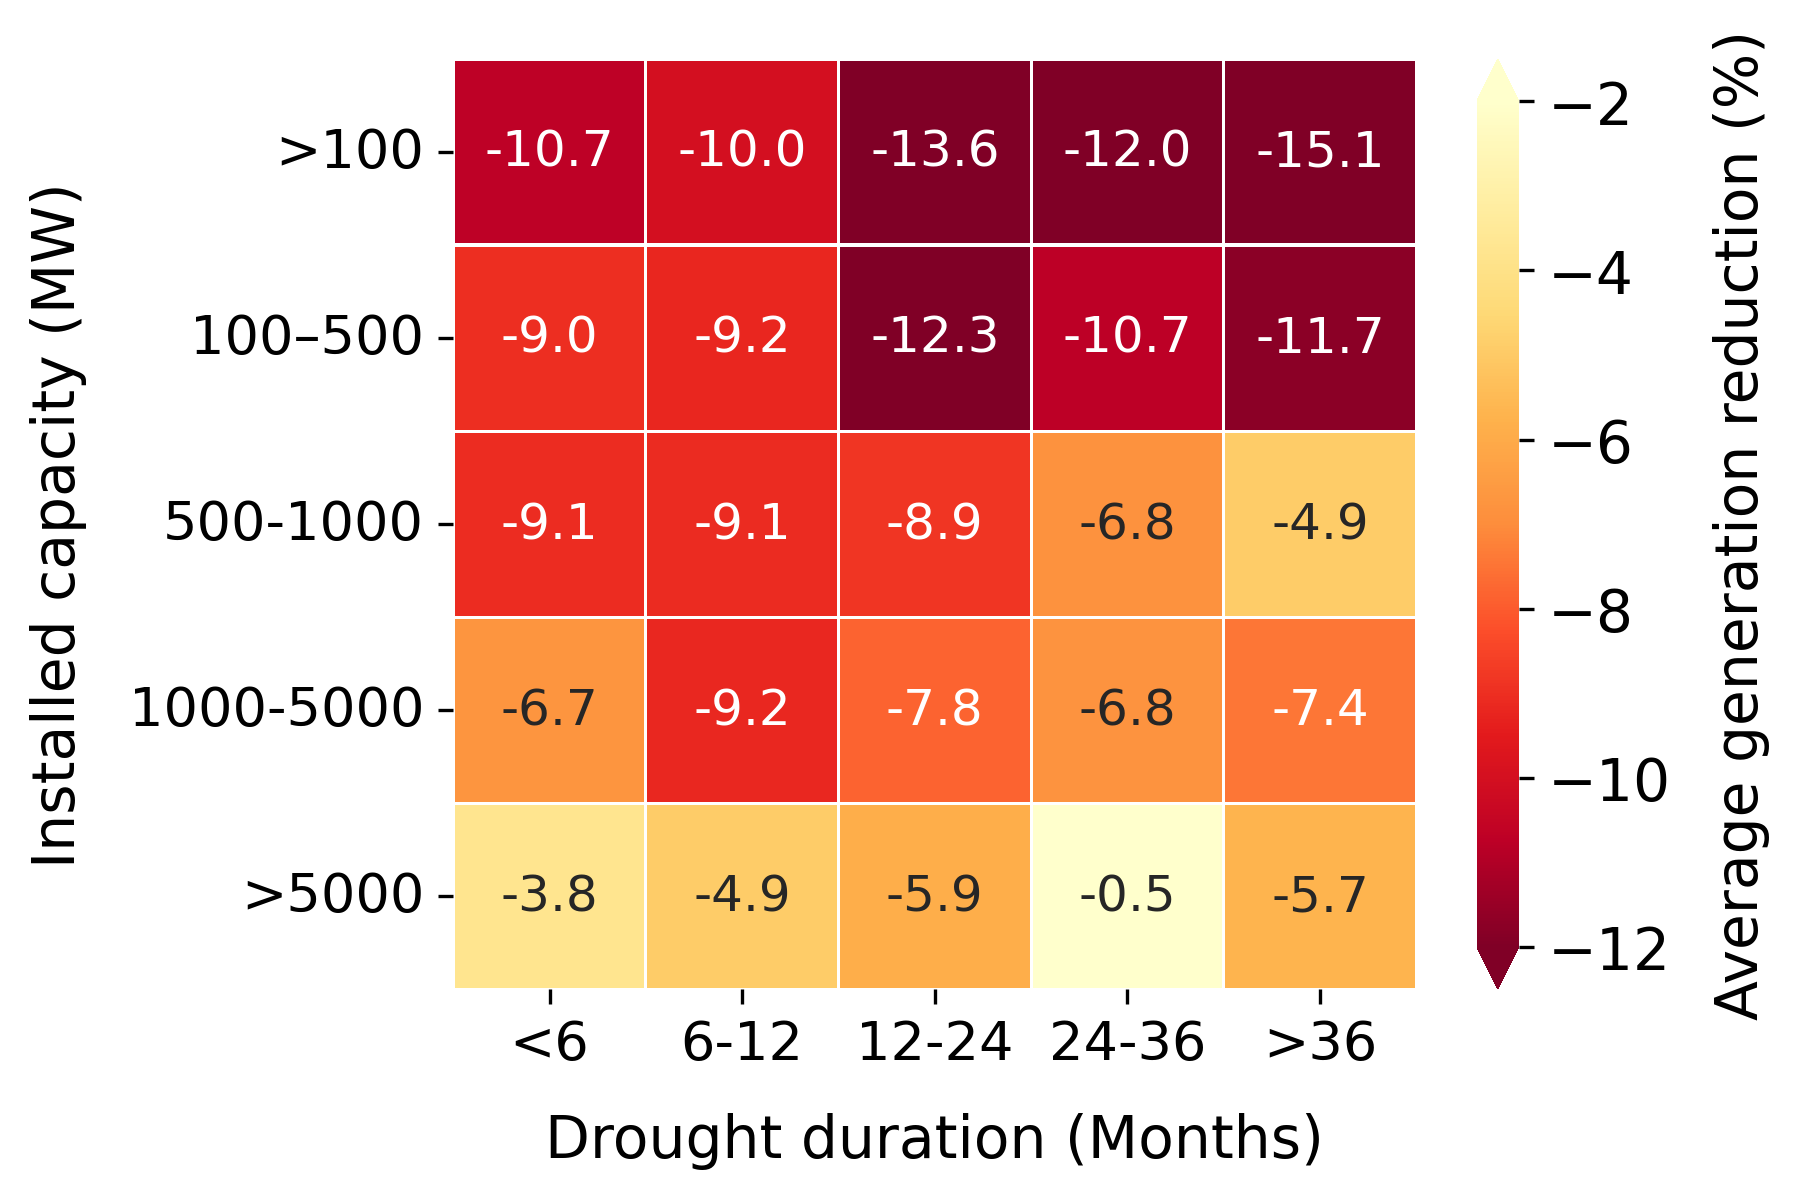

In [137]:
STO_average_deviation_each_drought = average_deviation_each_drought[average_deviation_each_drought.plant_type == "STO"]
plot_heatmap_installedcap_vs_drought_length(df = STO_average_deviation_each_drought, filename = "STO_heatmap_drought_reduction_installed_cap_drought_length")